In [1]:
%load_ext autoreload
%autoreload 2
from tools import *
import matplotlib.pyplot as plt
from nltk.tag.perceptron import PerceptronTagger
import nltk

In [2]:
# =============== chargement ============
filename = "dataWapiti/wapiti/chtrain.txt" # a modifier
filenameT = "dataWapiti/wapiti/chtest.txt" # a modifier

alldocs = load(filename)
alldocsT = load(filenameT)

print("{} docs read".format(len(alldocs)))
print("{} docs (T) read".format(len(alldocsT)))

823 docs read
77 docs (T) read


## I - Approche à base de dictionnaire :

In [4]:
d_train = create_dict_from_docs(alldocs)


In [5]:
score,n=eval_with_dict(d_train, alldocsT)
score,n

(1433, 1896)

In [6]:
perc=score*1./n*100
perc
#Cette méthode associe simplement chaque mot de la base d’apprentissage au tag qui lui correspond. 
#on remarque q'avec l'approche à base de dictionnaire sans raffinement on obtient une performance de 75.5 % (en cas d'ambiguïté, le dernier mot de la liste impose son choix)

75.58016877637131

In [7]:
# on va tester l'approche en metteant tout les mots en minuscules
alldocs_m=load_min(filename)
alldocsT_m=load_min(filenameT)

In [8]:
d_train = create_dict_from_docs(alldocs_m)
score,n=eval_with_dict(d_train, alldocsT_m)
perc=score*1./n*100
perc
#cela dégrade un peu les performances

74.73628691983122

In [9]:
#on va tester l'approche en appliquant de steeming sur tout les mots des documents en train et test
alldocs_s=load_stem(filename)
alldocsT_s=load_stem(filenameT)

In [10]:
d_train = create_dict_from_docs(alldocs_s)
score,n=eval_with_dict(d_train, alldocsT_s)
perc=score*1./n*100
perc
#le steeming degrade plus la performance puisque on perd des informations importantes pour le post-tagging

67.29957805907173

In [11]:
# on va pas faire des pretraitement mais pour les nouveaux mots inconnus en test  on va predire la classe majoritaire de document 
d_train = create_dict_from_docs(alldocs)
score,n=eval_with_dict_maj(d_train, alldocsT)
perc=score*1./n*100
perc
#cela améliore les performancees 

80.5379746835443

cette methode est rapide et simple à implementer mais on gnore le contexte de la phrase et on peut pas avoir différents tags pour un seul mot 

## Méthodes séquentielles


In [12]:
#on utilise les chaînes de Markov cachées pour apprendre les probabilités d’apparition des tags en fonction 
#de leur position dans la phrase. Ainsi Après avoir tourné le modèle on cherche les labels par maximum de vraisemblance
allx,allxT,allq,allqT,mots2ind,cles2ind=from_docs_to_sequences(alldocs,alldocsT)

In [13]:
N = len(cles2ind)
K = len(mots2ind)

In [14]:
Pi, A, B = learnHMM(allx, allq, N, K, initTo1=True)

In [42]:
resu=[]
psi = []
for x in allxT:
    resu.append(viterbi(x,Pi,A,B)[0])
    psi.append(viterbi(x,Pi,A,B)[3])

In [39]:
score = 0
n=0
confMat = np.zeros((len(A), len(A)))
for i in range(len(alldocsT)):
    for j in range(len(alldocsT[i])):
        n+=1
        if cles2ind[alldocsT[i][j][1]]==int(resu[i][j]):
            score+=1
        confMat[cles2ind[alldocsT[i][j][1]] - 1][int(resu[i][j]) - 1] += 1
score,n

(1536, 1896)

In [30]:
score*1./n *100

81.0126582278481

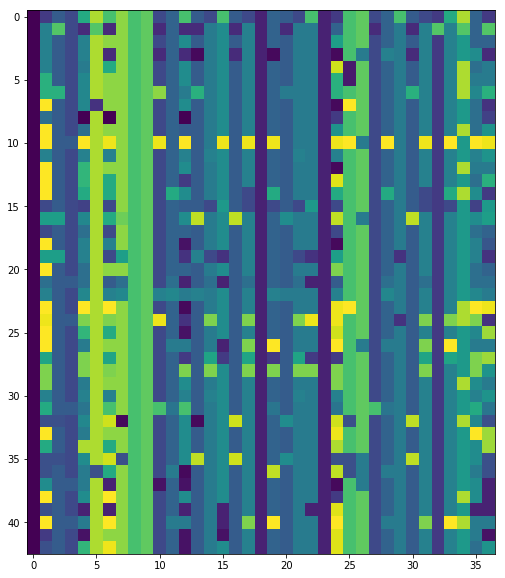

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(psi[0])

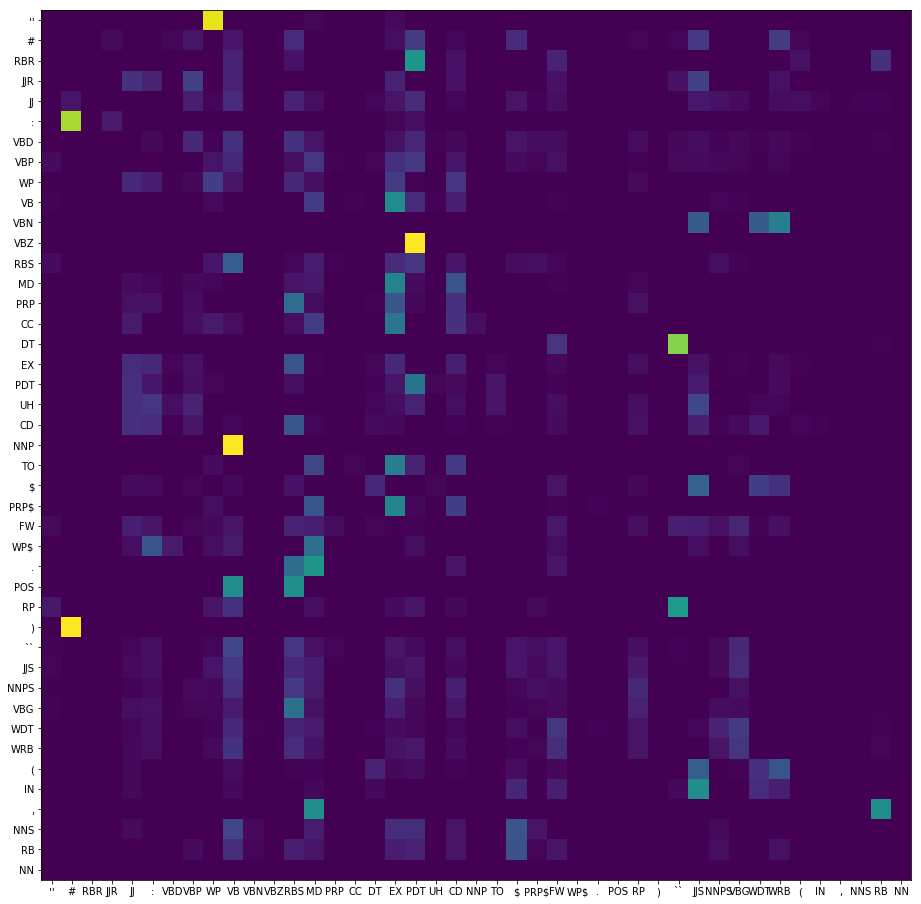

In [37]:
plt.figure(figsize=(16,16))
localLabs = np.unique(np.array(list(d_train.values())))
plt.imshow(A, interpolation='nearest')
localLabs = list(cles2ind.keys())  # liste des POS-TAG
plt.yticks(range(len(localLabs)), localLabs)  # affichage sur l'image
plt.xticks(range(len(localLabs)), localLabs)
plt.show()

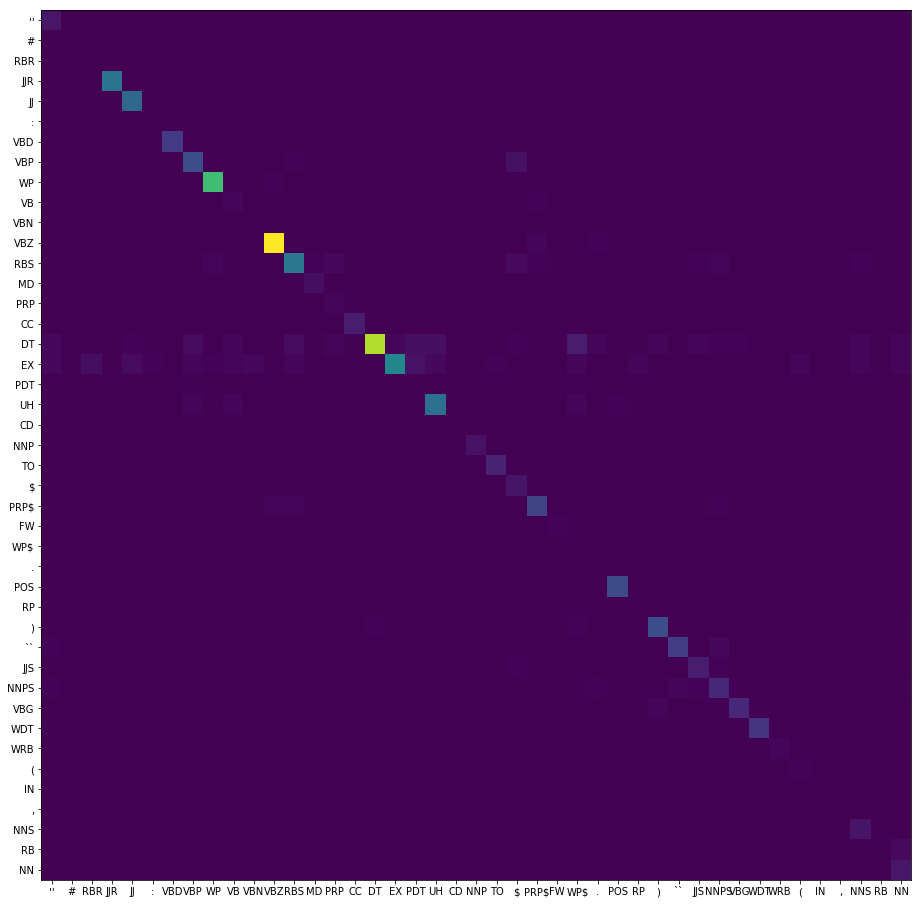

In [40]:
plt.figure(figsize=(16,16))
localLabs = np.unique(np.array(list(d_train.values())))
plt.imshow(confMat, interpolation='nearest')
localLabs = list(cles2ind.keys())  # liste des POS-TAG
plt.yticks(range(len(localLabs)), localLabs)  # affichage sur l'image
plt.xticks(range(len(localLabs)), localLabs)
plt.show()

cette methode est plus lente en prediction vu les calculs à faire à chaque fois

## Expériences dans nltk


In [50]:
tagger = PerceptronTagger(load=False)
tagger.train(alldocs)


In [56]:
adT_seq = from_docs_to_words(alldocsT)

In [57]:
allpred_smart  = [[t for w,t in tagger.tag(adT_seq[i])] for i in range(len(adT_seq))]
allpred_stupid = [[tagger.tag([w])[0][1] for w in adT_seq[i]] for i in range(len(adT_seq))]


In [74]:
score,n=eval_(allpred_smart, alldocsT)
perc=score*1./n*100
perc

91.82489451476793

In [75]:
score,n=eval_(allpred_stupid, alldocsT)
perc=score*1./n*100
perc

79.27215189873418

In [62]:
allpred_nltk  = [[t for w,t in nltk.pos_tag(adT_seq[i])] \
                 for i in range(len(adT_seq))]

In [77]:
score,n=eval_(allpred_nltk , alldocsT)
perc=score*1./n*100
perc
#on a des meilleurs performances avec pos-tagger pré-entrainé dans nltk

95.62236286919831